In [1]:
%matplotlib inline
import sys, os, time
import datetime
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from azure.cosmosdb.table.tableservice import TableService
from azure.cosmosdb.table.models import Entity

import rasterio

In [2]:
f = open("../setup_table_storage.sh")
lines = f.read().strip().split("\n")
AZURE_ACCOUNT_NAME = lines[0][26:]
AZURE_ACCOUNT_KEY = lines[1][25:]
f.close()

In [3]:
def assert_cnf_shape(cnf):
    assert len(cnf.shape) == 2
    assert cnf.shape[0] == cnf.shape[1]
    assert np.all(cnf>=0)
    
def confusion_matrix(y_true, y_pred, class_values):
    ''' y_true and y_pred should either be equally sized 1D or 2D arrays where entries indicate class values
    
    cnf[i,j] will be the number of entries that are labeled as class_values[i] in y_true, and labeled as class_values[j] in y_pred
    '''
    if isinstance(y_true, list):
        assert isinstance(y_pred, list)
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        assert len(y_true.shape) == 1 and len(y_pred.shape) == 1
    
    assert len(y_true.shape) == len(y_pred.shape)
    assert len(y_true.shape) <= 2 #
    for i in range(len(y_true.shape)):
        assert y_true.shape[i] == y_pred.shape[i]
    
    cnf = np.zeros((len(class_values), len(class_values)), dtype=np.int)
    
    for i in range(len(class_values)):
        class_i = class_values[i]
        mask = (y_true==class_i)
        for j in range(len(class_values)):
            class_j = class_values[j]
            cnf[i,j] = np.sum(mask & (y_pred==class_j))
    return cnf    

def mean_per_class_accuracy(cnf):
    assert_cnf_shape(cnf)
    
    accuracies = []
    for i in range(cnf.shape[0]):
        row_sum = np.sum(cnf[i,:])
        if row_sum != 0:
            accuracies.append(cnf[i,i] / row_sum)
    return np.mean(accuracies)

def miou(cnf):
    assert_cnf_shape(cnf)
    
    ious = []
    for i in range(cnf.shape[0]):
        iou = cnf[i,i] / (np.sum(cnf[i,:] + np.sum(cnf[:,i]) - cnf[i,i]))
        ious.append(iou)
    return np.mean(ious)

def accuracy(cnf):
    assert_cnf_shape(cnf)
    
    num_correct = 0
    for i in range(cnf.shape[0]):
        num_correct += cnf[i,i]
    
    return num_correct / np.sum(cnf)

In [4]:
def parse_task(task):

    neighborhood = np.array(list(map(int,task["neighborhood_19m"].split(",")))).reshape(19,19) 
    ground_truth_label = neighborhood[9,9]
    
    row = {
        "client_ip": task["client_ip"],
        "time_out": datetime.datetime.strptime(task["out_time"], "%c"),
        "time_in": datetime.datetime.strptime(task["in_time"], "%c"),
        "naip_fn": task["file_name"],
        "x": int(task["x"]),
        "y": int(task["y"]),
        "size": int(task["size"]),
        "user_label": int(task["user_label"]),
        "ground_truth_label": ground_truth_label,
        "number_of_times_labeled": int(task["number_of_times_labeled"])
    }
    
    return row

In [5]:
table_service = TableService(account_name=AZURE_ACCOUNT_NAME, account_key=AZURE_ACCOUNT_KEY)

In [6]:
all_tasks = table_service.query_entities('randomlabeltool')
all_tasks = [parse_task(task) for task in all_tasks]

In [7]:
len(all_tasks)

28973

In [8]:
all_tasks[-1]

{'client_ip': '73.185.97.128',
 'ground_truth_label': 2,
 'naip_fn': '/mnt/afs/code/chesapeake_denver_qaqc/naip_tiles/tile_59.tif',
 'number_of_times_labeled': 0,
 'size': 240,
 'time_in': datetime.datetime(2019, 8, 22, 18, 8, 40),
 'time_out': datetime.datetime(2019, 8, 22, 18, 8, 38),
 'user_label': 2,
 'x': 1105,
 'y': 845}

In [9]:
#tasks = [task for task in all_tasks if "md_1m_2013_extended-train_tiles" in task["naip_fn"]]
tasks = [task for task in all_tasks if "chesapeake_denver_qaqc" in task["naip_fn"]]
len(tasks)

17798

In [10]:
ip_counts = defaultdict(int)
for task in tasks:
    ip_counts[task["client_ip"]] += 1
sorted_ips = sorted(ip_counts, key=ip_counts.get)
print("%d unique ips" % (len(sorted_ips)))
# xs = []
# ys = []
# for ip in sorted_ips:
#     xs.append(ip)
#     ys.append(ip_counts[ip])
    
# plt.figure(figsize=(4,9))
# plt.barh(np.arange(len(xs)), ys)
# plt.yticks(np.arange(len(xs)), xs)
# plt.xlabel("Number of entries")
# plt.title("%d unique ips" % (len(ip_counts)))
# plt.show()
# plt.close()

86 unique ips


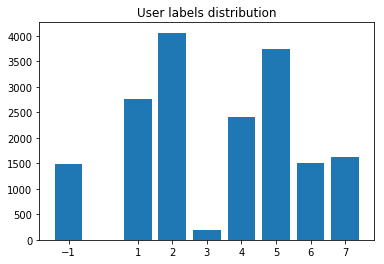

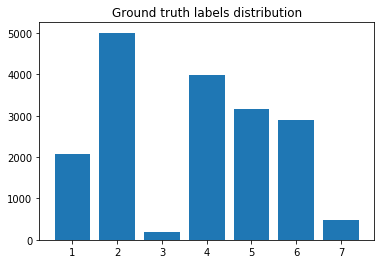

In [11]:
user_labels = []
gt_labels = []
for task in tasks:
    user_labels.append(task["user_label"])
    gt_labels.append(task["ground_truth_label"])

xs, ys = np.unique(user_labels, return_counts=True)
plt.figure()
plt.bar(xs, ys)
plt.xticks(xs)
plt.title("User labels distribution")
plt.show()
plt.close()

xs, ys = np.unique(gt_labels, return_counts=True)
plt.figure()
plt.bar(xs, ys)
plt.xticks(xs)
plt.title("Ground truth labels distribution")
plt.show()
plt.close()

# Filter bad users

In [23]:
user_points = defaultdict(list)

for task in tasks:
    user_points[task["client_ip"]].append(task)

### Filter users with < 50 labels

In [24]:
t_user_points = {}
num_filtered = 0
for k, vs in user_points.items():
    if len(vs) >= 50:
        t_user_points[k] = vs
    else:
        num_filtered += 1
user_points = t_user_points
print("Filtered %d users" % (num_filtered))

Filtered 23 users


### Filter users with < 0.7 accuracy with ground truth

In [25]:
t_user_points = {}
all_time_deltas = []
num_filtered = 0

user_table = {
    "client_ip": [],
    "median label time": [],
    "mean label time": [],
    "num unsure": [],
    "num water": [],
    "num forest": [],
    "num field": [],
    "num built": [],
    "num total": [],
    "acc with gt (ignoring unsure)": []
}

for k, vs in user_points.items():
    
    user_labels = []
    gt_labels = []
    time_deltas = []
    for task in vs:
        user_labels.append(task["user_label"])
        gt_labels.append(task["ground_truth_label"])
        
        time_delta = task["time_in"] - task["time_out"]
        time_deltas.append(time_delta.seconds)
        all_time_deltas.append(time_delta.seconds)
    
    user_label_counts = Counter(user_labels)
    
    user_labels = np.array(user_labels)
    gt_labels = np.array(gt_labels)    
    mask = user_labels != -1
    user_labels = user_labels[mask]
    gt_labels = gt_labels[mask]
    acc = np.sum(user_labels==gt_labels)/len(gt_labels)
    
    
    user_table["client_ip"].append(k)
    user_table["median label time"].append(np.median(time_deltas))
    user_table["mean label time"].append(np.mean(time_deltas))
    user_table["num unsure"].append(user_label_counts.get(-1,0))
    user_table["num water"].append(user_label_counts.get(1,0))
    user_table["num forest"].append(user_label_counts.get(2,0))
    user_table["num field"].append(user_label_counts.get(3,0))
    user_table["num built"].append(user_label_counts.get(4,0))
    user_table["num total"].append(len(user_labels))
    user_table["acc with gt (ignoring unsure)"].append(acc)
    
    
    if acc >= 0.6:
        t_user_points[k] = vs
    else:
        num_filtered += 1
    
user_points = t_user_points
print("Filtered %d users" % (num_filtered))

Filtered 25 users


In [26]:
user_label_counts

Counter({-1: 21, 1: 37, 2: 67, 3: 3, 4: 23, 5: 41, 6: 26, 7: 16})

In [27]:
user_table = pd.DataFrame.from_dict(user_table)

In [28]:
user_table["acc with gt (ignoring unsure)"].median()

0.636

In [29]:
user_table["num total"].median()

168.0

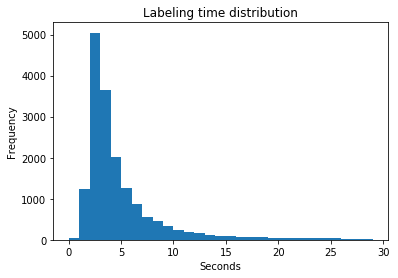

In [30]:
plt.figure()
plt.hist(all_time_deltas, bins=np.arange(0, 30))
plt.xlabel("Seconds")
plt.ylabel("Frequency")
plt.title("Labeling time distribution")
plt.show()
plt.close()

In [31]:
np.mean(all_time_deltas)

13.629414805030724

In [32]:
np.median(all_time_deltas)

3.0

# Point analysis

In [33]:
filtered_tasks = []
for k, vs in user_points.items():
    for task in vs:
        filtered_tasks.append(task)
print(len(filtered_tasks))

10576


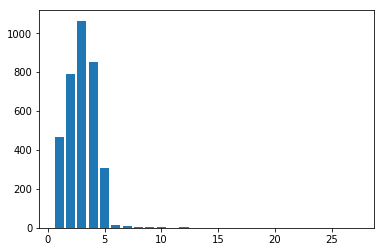

3522


In [34]:
points = defaultdict(list)
for task in filtered_tasks:
    idx = "%s_%d_%d" % (task["naip_fn"], task["x"], task["y"])
    points[idx].append(task)
    
counts = []
for k, vs in points.items():
    counts.append(len(vs))

xs, ys = np.unique(counts, return_counts=True)
plt.figure()
plt.bar(xs, ys)
plt.show()
plt.close()

print(len(points))

In [91]:
def get_majority(labels):
    vals, counts = np.unique(labels, return_counts=True)
    
    count_tuples = list(zip(vals, counts))
    
    sorted_vals = sorted(count_tuples, key=lambda x: x[1], reverse=True)

    if len(sorted_vals) == 1:
        return sorted_vals[0][0]
    else:
        total_sum = np.sum(counts)
        if sorted_vals[0][1] > (total_sum - sorted_vals[0][1]):
            return sorted_vals[0][0]
        else:
            return -2

num_unsure = 0
num_no_majority = 0

num_agree_majority = 0
num_total_majority = 0

all_user_labels = []
all_gt_labels = []

example_points = defaultdict(list)

for k, vs in points.items():
    if len(vs) == 3 or len(vs) == 5:
        
        user_labels = []
        gt_labels = []
        for point in vs:
            user_labels.append(point["user_label"])
            gt_labels.append(point["ground_truth_label"])
        
        vals = np.unique(gt_labels)
        assert len(vals) == 1
        gt_label = vals[0]
        
        true_label = get_majority(user_labels)
        
        all_user_labels.append(true_label)
        all_gt_labels.append(gt_label)
        
        example_points[(true_label, gt_label)].append(vs[0])
        
        if true_label == -1: # The "Not sure" class was the majority
            num_unsure += 1
        elif true_label == -2: # There was no majority:
            num_no_majority += 1
        else:
        
            if true_label == gt_label:
                num_agree_majority += 1
            num_total_majority += 1

print(num_unsure, num_no_majority, num_agree_majority, num_total_majority)
print(num_agree_majority / (num_total_majority))

74 116 865 1179
0.7336726039016115


In [92]:
len(points)

3522

In [93]:
chesapeake_labels = ["Water", "Forest", "Field", "Built"]
denver_labels = ["Structures", "Impervious Surfaces", "Water", "Grassland/Prairie", "Tree Canopy", "Turf/Irrigated Lands", "Barren/Rock"]

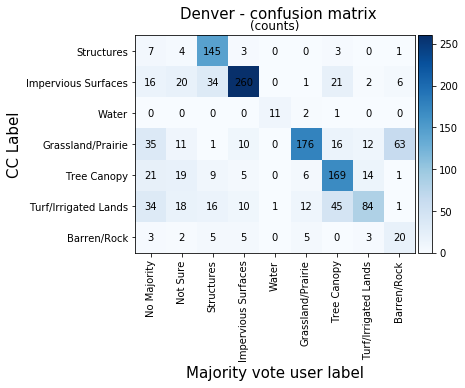

In [96]:
cnf = confusion_matrix(all_gt_labels, all_user_labels, [-2,-1,1,2,3,4,5,6,7])
#cnf = cnf / cnf.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(6,4))

im = ax.imshow(cnf, vmin=0, vmax=None, cmap="Blues")

plt.ylim([8.5,1.5])
plt.yticks(np.arange(2,9), denver_labels)
plt.ylabel("CC Label", fontsize=15)
plt.xlabel("Majority vote user label", fontsize=15)
plt.xticks(np.arange(9), ["No Majority", "Not Sure"] + denver_labels, rotation=90)

for i in range(2,9):
    for j in range(9):
        plt.text(j,i,"%d" % (cnf[i,j]), horizontalalignment="center", verticalalignment="center")

plt.suptitle("Denver - confusion matrix", fontsize=15)
plt.title("(counts)", fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()
plt.close()

In [97]:
cnf

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  7,   4, 145,   3,   0,   0,   3,   0,   1],
       [ 16,  20,  34, 260,   0,   1,  21,   2,   6],
       [  0,   0,   0,   0,  11,   2,   1,   0,   0],
       [ 35,  11,   1,  10,   0, 176,  16,  12,  63],
       [ 21,  19,   9,   5,   0,   6, 169,  14,   1],
       [ 34,  18,  16,  10,   1,  12,  45,  84,   1],
       [  3,   2,   5,   5,   0,   5,   0,   3,  20]])

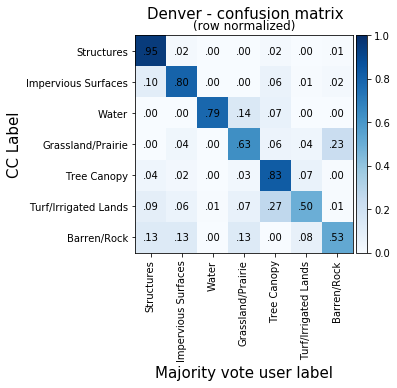

In [95]:
cnf = confusion_matrix(all_gt_labels, all_user_labels, [1,2,3,4,5,6,7])
cnf = cnf / cnf.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(6,4))

im = ax.imshow(cnf, vmin=0, vmax=1, cmap="Blues")

plt.ylim([6.5,-0.5])
plt.yticks(np.arange(7), denver_labels)
plt.ylabel("CC Label", fontsize=15)
plt.xlabel("Majority vote user label", fontsize=15)
plt.xticks(np.arange(7), denver_labels, rotation=90)

for i in range(7):
    for j in range(7):
        plt.text(j,i,("%.2f" % (cnf[i,j])).lstrip('0'), horizontalalignment="center", verticalalignment="center")

plt.title("(row normalized)", fontsize=12)
plt.suptitle("Denver - confusion matrix",fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()
plt.close()

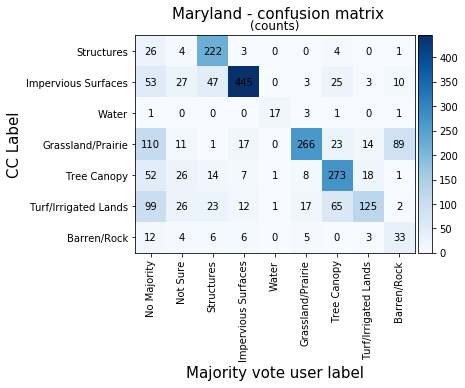

In [47]:
cnf = confusion_matrix(all_gt_labels, all_user_labels, [-2,-1,1,2,3,4])
#cnf = cnf / cnf.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(6,4))

im = ax.imshow(cnf, vmin=0, vmax=None, cmap="Blues")

plt.ylim([5.5,1.5])
plt.yticks(np.arange(2,6), ["Water", "Forest", "Field", "Built"])
plt.ylabel("CC Label", fontsize=15)
plt.xlabel("Majority vote user label", fontsize=15)
plt.xticks(np.arange(6), ["No Majority", "Not Sure", "Water", "Forest", "Field", "Built"], rotation=90)

for i in range(2,6):
    for j in range(6):
        plt.text(j,i,"%d" % (cnf[i,j]), horizontalalignment="center", verticalalignment="center")

plt.suptitle("Maryland - confusion matrix", fontsize=15)
plt.title("(counts)", fontsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()
plt.close()

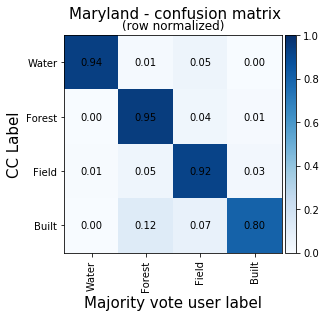

In [23]:
cnf = confusion_matrix(all_gt_labels, all_user_labels, [1,2,3,4])
cnf = cnf / cnf.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(6,4))

im = ax.imshow(cnf, vmin=0, vmax=1, cmap="Blues")

plt.ylim([3.5,-0.5])
plt.yticks(np.arange(4), ["Water", "Forest", "Field", "Built"])
plt.ylabel("CC Label", fontsize=15)
plt.xlabel("Majority vote user label", fontsize=15)
plt.xticks(np.arange(4), ["Water", "Forest", "Field", "Built"], rotation=90)

for i in range(4):
    for j in range(4):
        plt.text(j,i,"%0.2f" % (cnf[i,j]), horizontalalignment="center", verticalalignment="center")

plt.title("(row normalized)", fontsize=12)
plt.suptitle("Maryland - confusion matrix",fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()
plt.close()

In [24]:
cnf = confusion_matrix(all_gt_labels, all_user_labels, [1,2,3,4])

In [59]:
print(accuracy(cnf))
print(mean_per_class_accuracy(cnf))
print(miou(cnf))

0.7431848057666004
0.7431848057666003
0.31277004277253645


In [60]:
example_points.keys()

dict_keys([(7, 3), (4, 7), (-1, 5), (6, 6), (5, 6), (7, 7), (2, 1), (2, 6), (1, 6), (-2, 5), (5, 1), (2, 5), (7, 2), (1, 2), (-2, 1), (6, 7), (5, 5), (-1, 7), (7, 6), (4, 4), (1, 5), (3, 6), (2, 2), (5, 3), (1, 1), (-1, 6), (6, 4), (5, 4), (-2, 2), (7, 1), (4, 5), (-1, 2), (-1, 1), (1, 4), (7, 5), (-2, 4), (4, 2), (-2, 7), (6, 5), (3, 3), (2, 7), (4, 6), (-2, 3), (7, 4), (3, 5), (6, 2), (4, 3), (1, 7), (-1, 4), (-2, 6), (5, 2), (2, 4)])

In [58]:
def plot_point(task, zoom=0, fn=None):
    f = rasterio.open(task["naip_fn"], "r")
    data = f.read()
    data = np.rollaxis(data, 0, 3)
    f.close()
    
    x,y,size = task["x"], task["y"], task["size"]
    
    if zoom == 1:
        x += 60
        y += 60
        size = 120
    elif zoom == 2:
        x += 110
        y += 110
        size = 20
    
    fig, ax = plt.subplots(figsize=(4,4))
    
    ax.imshow(data[y:y+size, x:x+size, :3])    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    if fn is None:
        plt.tight_layout()
        plt.show()
    else:
        plt.savefig(fn, bbox_inches='tight', pad_inches = 0)
    plt.close()

In [74]:
def plot_point_all_zoom(task, title=None, fn=None):
    f = rasterio.open(task["naip_fn"], "r")
    data = f.read()
    data = np.rollaxis(data, 0, 3)
    f.close()
    
    x,y,size = task["x"], task["y"], task["size"]
    
    fig, axs = plt.subplots(1,3,figsize=(8,4))
    
    axs[0].imshow(data[y:y+size, x:x+size, :3])
    x += 60
    y += 60
    size = 120
    axs[1].imshow(data[y:y+size, x:x+size, :3])
    x += 50
    y += 50
    size = 20
    axs[2].imshow(data[y:y+size, x:x+size, :3])
    
    for i in range(3):
        axs[i].axes.get_xaxis().set_visible(False)
        axs[i].axes.get_yaxis().set_visible(False)
        axs[i].set_frame_on(False)
    
    if title is not None:
        axs[1].set_title(title)
    
    if fn is None:
        plt.tight_layout()
        plt.show()
    else:
        plt.savefig(fn, bbox_inches='tight', pad_inches = 0)
    plt.close()

In [75]:
label_map = ["No Majority", "Not Sure"] + denver_labels 
for i,u in enumerate([-2,-1,1,2,3,4,5,6,7]):
    for j,v in enumerate([-2,-1,1,2,3,4,5,6,7]):
        if u != v and len(example_points[(u,v)]) > 2:
            for k in range(3):
                title = "Users: %s   Data: %s" % (label_map[i], label_map[j])
                plot_point_all_zoom(example_points[(u,v)][k], title, "../output/misclassification_user_%d_gt_%d_example_%d.png" % (u,v,k))

In [29]:
for u in [-2,-1,1,2,3,4]:
    for v in [-2,-1,1,2,3,4]:
        if u == v and len(example_points[(u,v)]) > 1:
            for j in [0,1]:
                plot_point(example_points[(u,v)][j], 1, "../output/agreement_%d_example_%d_zoom_1.png" % (u,j))
                plot_point(example_points[(u,v)][j], 2, "../output/agreement_%d_example_%d_zoom_2.png" % (u,j))